# Step Detection Log Analysis

## Raw vs Filtered

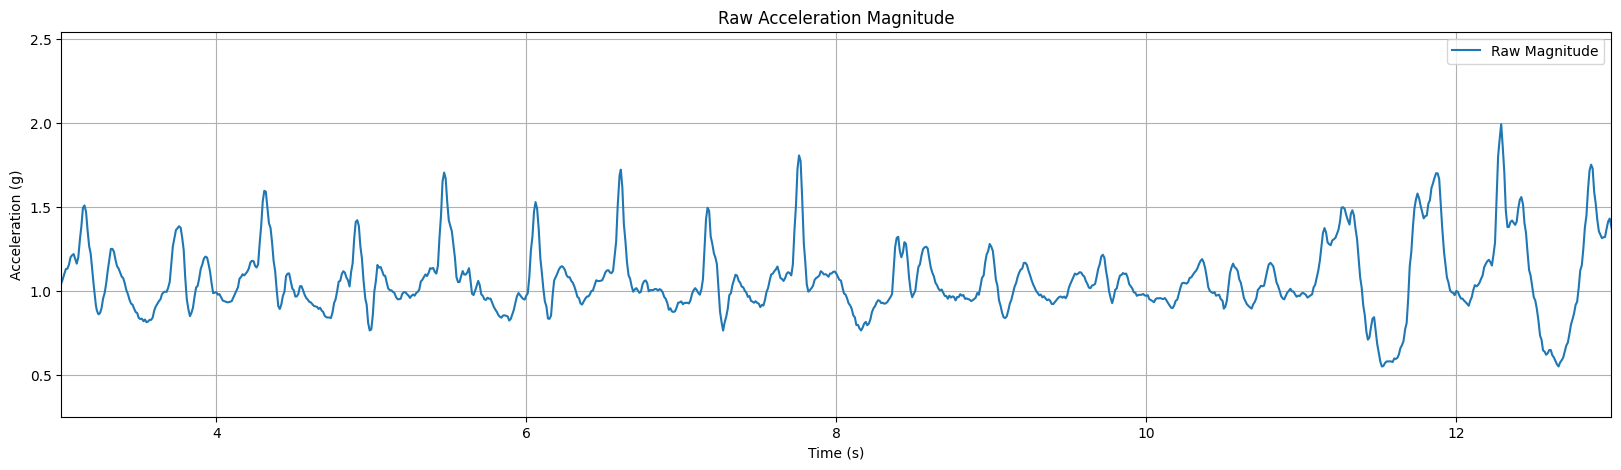

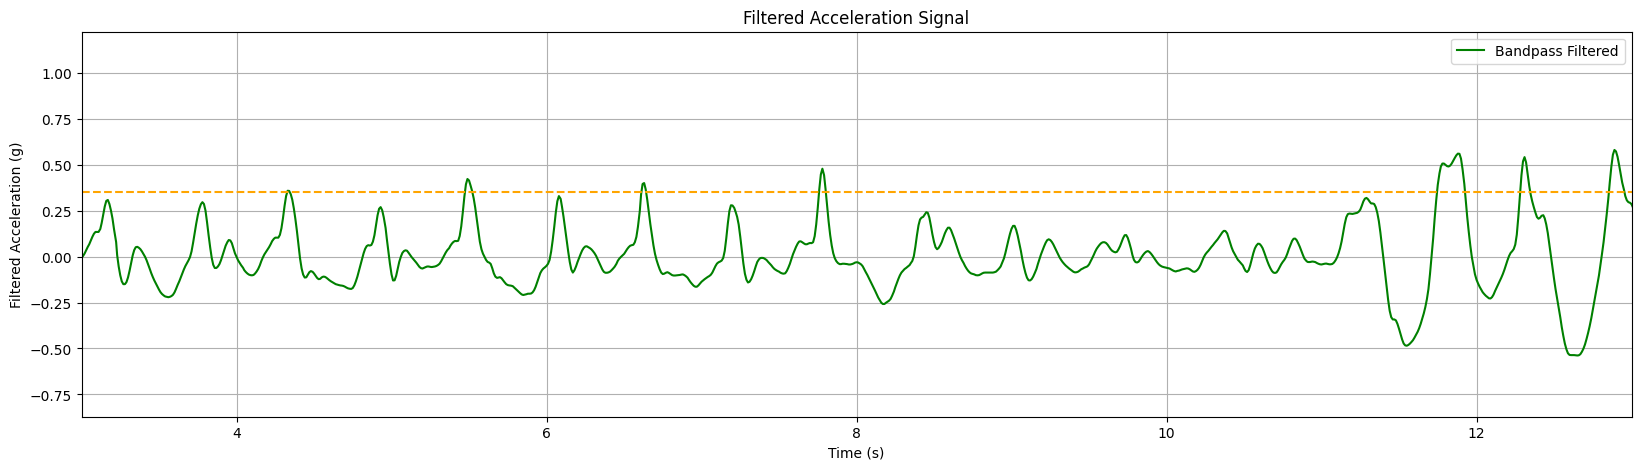

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Load the data
df = pd.read_csv('Walking4.csv')

# Convert timestamp to seconds and create time axis
df['timestamp_s'] = df['timestamp_us'] / 1e6
df['time_elapsed'] = df['timestamp_s'] - df['timestamp_s'].iloc[0]

start = 3  
end = start + 10



# Raw vs Filtered Signal Visualization
plt.figure(figsize=(20, 5))
plt.plot(df['time_elapsed'], df['raw_mag'], label='Raw Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw Acceleration Magnitude')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
threshold = 1.3
#plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(df['time_elapsed'], df['filtered'], label='Bandpass Filtered', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Acceleration (g)')
plt.title('Filtered Acceleration Signal')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
threshold = 0.35
plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.show()

## Filtered vs SciPy

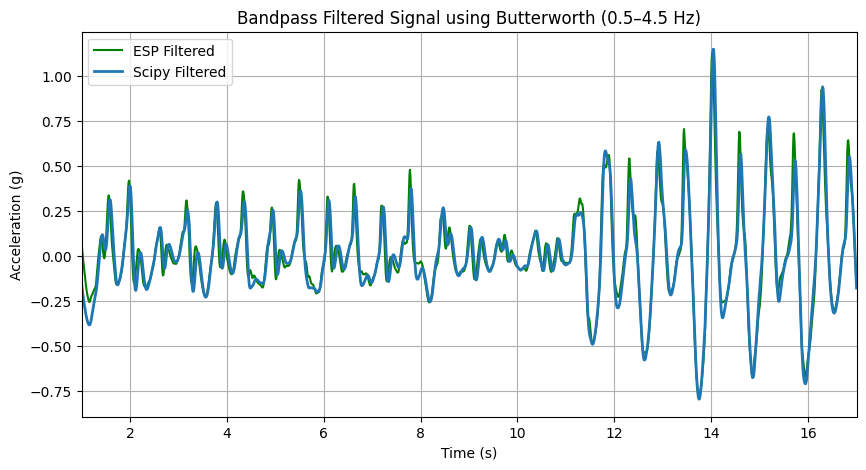

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


fs = 100  # Sampling frequency in Hz
low_cut = 0.5
high_cut = 4.5

# Normalize the frequencies
low = low_cut / (fs / 2)
high = high_cut / (fs / 2)

b, a = butter(N=2, Wn=[low, high], btype='band')
df['scipy_butter'] = lfilter(b, a, df['raw_mag'])

plt.figure(figsize=(10, 5))
plt.plot(df['time_elapsed'], df['filtered'], label='ESP Filtered', color='green')
plt.plot(df['time_elapsed'], df['scipy_butter'], label='Scipy Filtered', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Bandpass Filtered Signal using Butterworth (0.5–4.5 Hz)')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
plt.show()


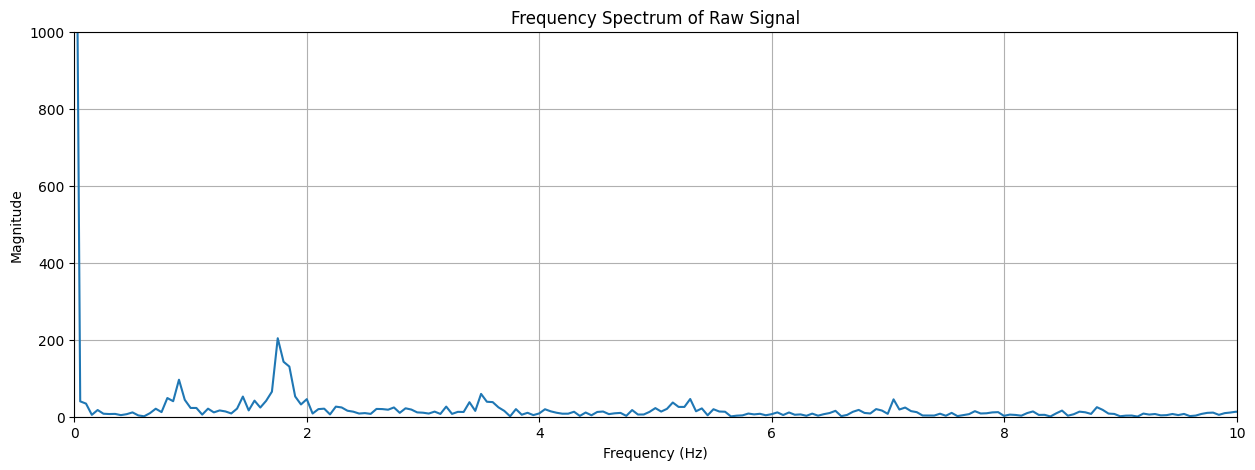

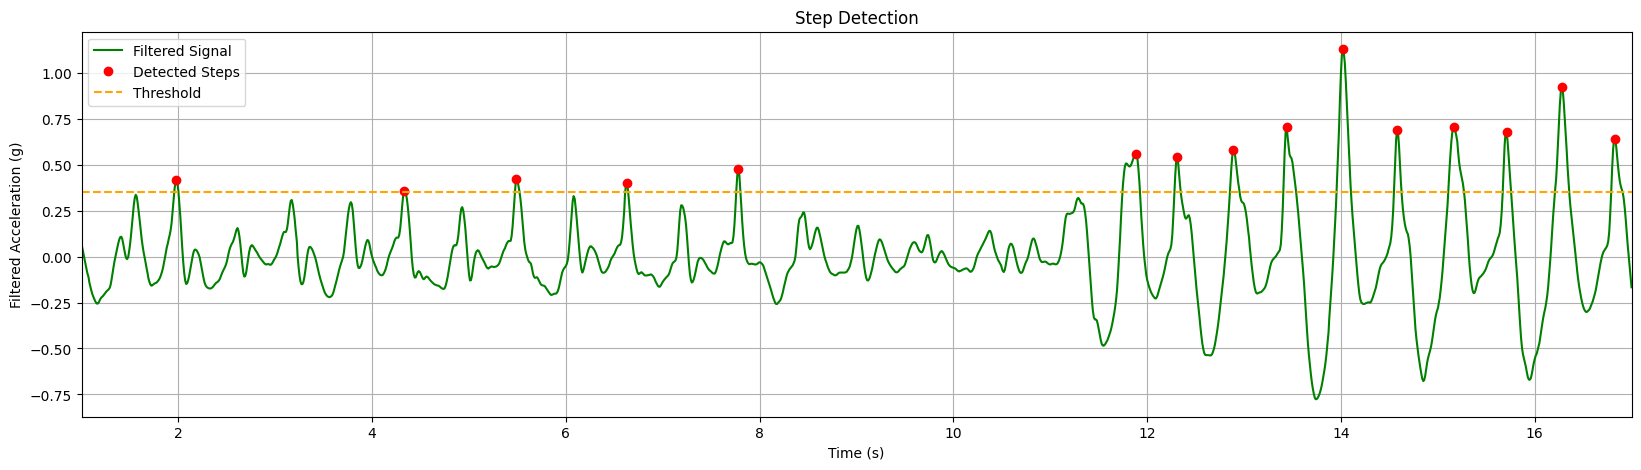

In [96]:
# Frequency Domain Analysis
sample_rate = 100  # Hz (from your 10ms sample period)
n = len(df)
yf = fft(df['raw_mag'].values)
xf = fftfreq(n, 1/sample_rate)

plt.figure(figsize=(15, 5))
plt.plot(xf[:n//2], np.abs(yf[:n//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Raw Signal')
plt.xlim(0, 10)  # Focus on 0-10Hz range
plt.ylim(0, 1000)
plt.grid(True)
plt.show()

# Step Detection Simulation
threshold = 0.35  #threshold from C code
min_step_interval = 0.3  # 300ms in seconds

# Find peaks in the filtered signal
peaks, _ = signal.find_peaks(df['filtered'], height=threshold, distance=int(min_step_interval*sample_rate))

# Plot with detected steps
plt.figure(figsize=(20, 5))
plt.plot(df['time_elapsed'], df['filtered'], label='Filtered Signal', color='green')
plt.plot(df['time_elapsed'].iloc[peaks], df['filtered'].iloc[peaks], 
         'ro', label='Detected Steps')
plt.axhline(threshold, color='orange', linestyle='--', label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Acceleration (g)')
plt.title(f'Step Detection')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
plt.show()

In [97]:
from scipy.signal import butter

fs = 100  # Sample rate in Hz
low = 0.5 / (fs / 2)
high = 4.5 / (fs / 2)

b, a = butter(N=1, Wn=[low, high], btype='band')  # 2nd-order bandpass
print("New coefficients:")
print(f"#define BP_B0  {b[0]:.6f}f")
print(f"#define BP_B1  {b[1]:.6f}f")
print(f"#define BP_B2  {b[2]:.6f}f")
print(f"#define BP_A1  {a[1]:.6f}f")
print(f"#define BP_A2  {a[2]:.6f}f")

New coefficients:
#define BP_B0  0.112160f
#define BP_B1  0.000000f
#define BP_B2  -0.112160f
#define BP_A1  -1.767757f
#define BP_A2  0.775680f
